In [53]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [54]:

def sample_reserve_prices(n_samples=1):
    """
    Samples n_samples reserve prices based on a triangular distribution
    from 900 to 1000 with the mode at 1000, reflecting a linear increase in probability.
    """
    return np.random.triangular(900, 1000, 1000, n_samples)

def set_bid_strategy(samples, strategy='simple'):
    """
    Sets the lowest and highest bid based on the sampled reserve prices.
    The simple strategy sets the lowest bid just above the minimum to avoid unlikely low prices,
    and the highest bid near the maximum but with consideration for budget and purchase goals.
    """
    if strategy == 'simple':
        lowest_bid = np.min(samples) + (np.max(samples) - np.min(samples)) * 0.05  # 5% above the minimum
        highest_bid = np.max(samples) - (np.max(samples) - np.min(samples)) * 0.05 # 5% below the maximum
        return lowest_bid, highest_bid

# Example usage:
n_samples = 10000  # Number of samples to model the reserve prices
samples = sample_reserve_prices(n_samples)
lowest_bid, highest_bid = set_bid_strategy(samples)
print(f"Lowest Bid: {lowest_bid:.2f}, Highest Bid: {highest_bid:.2f}")

Lowest Bid: 905.22, Highest Bid: 995.00


array([[<Axes: title={'center': '0'}>]], dtype=object)

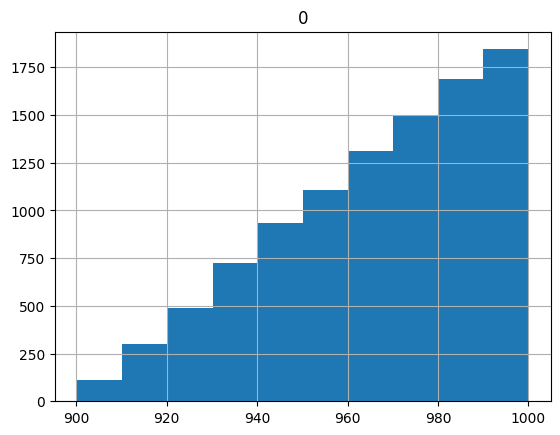

In [55]:
pd.DataFrame(samples).hist()

In [56]:
samples_less_than_950 = samples[samples < 950]
samples_greater = samples[samples >= 950]


In [57]:
len(samples_less_than_950)


2547

In [58]:
len(samples_greater)

7453

In [59]:
# simulate, set lowest bid at 901, change highest bid through iterations
# if lowest bid wins, you get $99 profit. If highest bid wins, you're hedged and still make money. 

def simulate_purchases(lowest_price, highest_price, n_simulations=100):
    """
    Simulates n_simulations of purchases based on a bid price.
    Returns the number of successful purchases and the average purchase price.
    """
    # Sample reserve prices based on a triangular distribution as before
    reserve_prices = np.random.triangular(900, 1000, 1000, n_simulations)
    loss = 0
    gain = 0
    for i in reserve_prices:
        if i < lowest_price:
            loss = loss + lowest_price - i
            gain = gain + 1000 - lowest_price
        elif i < highest_price:
            loss = loss + highest_price - i
            gain = gain + 1000 - highest_price
            
    return loss, gain

In [60]:
low = 947
high = 965
loss, gain = simulate_purchases(947, 965, 100000)

print(f"Lowest bid", 947, "Highest bid", 965, "Loss", "$", loss, "\n",
      "Profit", "$", gain, "\n"
      "Diff $", gain - loss)

Lowest bid 947 Highest bid 965 Loss $ 514916.23926284414 
 Profit $ 1868513 
Diff $ 1353596.7607371558


In [61]:
def optimize_bids(step=1):
    best_diff = -np.inf
    best_lowest = None
    best_highest = None
    for lowest_bid in range(900, 1000, step):
        for highest_bid in range(lowest_bid, 1000 + step, step):
            loss, gain = simulate_purchases(lowest_bid, highest_bid, 10000)
            diff = gain - loss
            if diff > best_diff:
                best_diff = diff
                best_lowest = lowest_bid
                best_highest = highest_bid
    return best_lowest, best_highest, best_diff

best_lowest, best_highest, best_diff = optimize_bids(1)  # Using a step of 5 for faster computation
print(f"Optimal Lowest Bid: {best_lowest}, Optimal Highest Bid: {best_highest}, Max Diff: {best_diff}")

Optimal Lowest Bid: 944, Optimal Highest Bid: 963, Max Diff: 140338.3263040093


In [62]:
# run a bunch of sims on optimize bids to see if it's consistent
# store the results in a list
results = []
for i in range(0, 2000):
    best_lowest, best_highest, best_diff = optimize_bids(1)
    print(f"Optimal Lowest Bid: {best_lowest}, Optimal Highest Bid: {best_highest}, Max Diff: {best_diff}")
    results.append([best_lowest, best_highest, best_diff])

Optimal Lowest Bid: 938, Optimal Highest Bid: 965, Max Diff: 140624.6872665106
Optimal Lowest Bid: 939, Optimal Highest Bid: 962, Max Diff: 140729.04353187693
Optimal Lowest Bid: 945, Optimal Highest Bid: 963, Max Diff: 142582.77399745624
Optimal Lowest Bid: 941, Optimal Highest Bid: 964, Max Diff: 140013.60259472072
Optimal Lowest Bid: 940, Optimal Highest Bid: 963, Max Diff: 142047.59660948644
Optimal Lowest Bid: 944, Optimal Highest Bid: 965, Max Diff: 140972.63467877157
Optimal Lowest Bid: 943, Optimal Highest Bid: 964, Max Diff: 142024.16042807116
Optimal Lowest Bid: 945, Optimal Highest Bid: 967, Max Diff: 140957.80718359898
Optimal Lowest Bid: 943, Optimal Highest Bid: 964, Max Diff: 140618.45174946848
Optimal Lowest Bid: 939, Optimal Highest Bid: 961, Max Diff: 140192.33539875638
Optimal Lowest Bid: 945, Optimal Highest Bid: 965, Max Diff: 141199.52658499853
Optimal Lowest Bid: 942, Optimal Highest Bid: 966, Max Diff: 141750.4829899926
Optimal Lowest Bid: 943, Optimal Highest B

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(results).to_csv("plot dists.csv")